In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitions/csiro-biomass/sample_submission.csv
/kaggle/input/competitions/csiro-biomass/train.csv
/kaggle/input/competitions/csiro-biomass/test.csv
/kaggle/input/competitions/csiro-biomass/test/ID1001187975.jpg
/kaggle/input/competitions/csiro-biomass/train/ID2099464826.jpg
/kaggle/input/competitions/csiro-biomass/train/ID2037861084.jpg
/kaggle/input/competitions/csiro-biomass/train/ID1211362607.jpg
/kaggle/input/competitions/csiro-biomass/train/ID1853508321.jpg
/kaggle/input/competitions/csiro-biomass/train/ID193102215.jpg
/kaggle/input/competitions/csiro-biomass/train/ID698608346.jpg
/kaggle/input/competitions/csiro-biomass/train/ID1859251563.jpg
/kaggle/input/competitions/csiro-biomass/train/ID1880764911.jpg
/kaggle/input/competitions/csiro-biomass/train/ID853954911.jpg
/kaggle/input/competitions/csiro-biomass/train/ID1403107574.jpg
/kaggle/input/competitions/csiro-biomass/train/ID1781353117.jpg
/kaggle/input/competitions/csiro-biomass/train/ID384648061.jpg
/kaggle/i

In [2]:
# ============================================================
# CELL 1 │ IMPORTS + DATA LOAD + PROBLEM UNDERSTANDING
# ============================================================
# WHY: Establish the full picture before touching any data.
# Knowing the metric structure (Dry_Total_g = 50% weight) shapes
# every downstream decision: model choice, loss function, CV strategy.
# ============================================================

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from PIL import Image
from scipy import stats

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 110

# ── Paths ──────────────────────────────────────────────────────────────────
ROOT      = Path("/kaggle/input/competitions/csiro-biomass")
TRAIN_DIR = ROOT / "train"
TEST_DIR  = ROOT / "test"

train_df  = pd.read_csv(ROOT / "train.csv")
test_df   = pd.read_csv(ROOT / "test.csv")
sub_df    = pd.read_csv(ROOT / "sample_submission.csv")

# ── Problem Summary ────────────────────────────────────────────────────────
print("=" * 65)
print("PROBLEM TYPE : Multi-output regression (long-format)")
print("TARGETS      : Dry_Green_g | Dry_Dead_g | Dry_Clover_g | GDM_g | Dry_Total_g")
print("METRIC       : Globally Weighted R²")
print()
print("TARGET WEIGHTS (score impact):")
weights = {"Dry_Green_g": 0.10, "Dry_Dead_g": 0.10,
           "Dry_Clover_g": 0.10, "GDM_g": 0.20, "Dry_Total_g": 0.50}
for t, w in weights.items():
    bar = "█" * int(w * 40)
    print(f"  {t:<15} {w:.2f}  {bar}")

print()
print("⚡ KEY INSIGHT: Dry_Total_g alone drives 50% of your score.")
print("   GDM_g (20%) + Dead (10%) + Green (10%) + Clover (10%) = 50%")
print("   STRUCTURAL IDENTITY: Dry_Total_g ≈ GDM_g + Dry_Dead_g")
print("   STRUCTURAL IDENTITY: GDM_g       ≈ Dry_Green_g + Dry_Clover_g")
print("   → Exploit these constraints as consistency regularization!")
print()

# ── Basic Shape ────────────────────────────────────────────────────────────
print("=" * 65)
print(f"Train rows   : {len(train_df):,}  ({len(train_df)//5:,} unique images × 5 targets)")
print(f"Test rows    : {len(test_df):,}   ({len(test_df)//5:,} unique images × 5 targets)")
print(f"Train columns: {train_df.columns.tolist()}")
print(f"Test columns : {test_df.columns.tolist()}")

# ── Data Types & Missing Values ────────────────────────────────────────────
print("\n── dtypes & nulls ──")
info = pd.DataFrame({
    "dtype":   train_df.dtypes,
    "nulls":   train_df.isnull().sum(),
    "null_%":  (train_df.isnull().mean() * 100).round(2)
})
print(info.to_string())

# ── Summary Stats for numeric cols ────────────────────────────────────────
print("\n── Numeric Summary ──")
print(train_df.describe(percentiles=[.05, .25, .5, .75, .95]).T.to_string())

# ── Unique Images ──────────────────────────────────────────────────────────
n_unique_train = train_df["image_path"].nunique()
n_unique_test  = test_df["image_path"].nunique()
print(f"\nUnique train images : {n_unique_train}")
print(f"Unique test images  : {n_unique_test}")
print(f"\nAll 5 targets per image? Train: {len(train_df)==n_unique_train*5}")

PROBLEM TYPE : Multi-output regression (long-format)
TARGETS      : Dry_Green_g | Dry_Dead_g | Dry_Clover_g | GDM_g | Dry_Total_g
METRIC       : Globally Weighted R²

TARGET WEIGHTS (score impact):
  Dry_Green_g     0.10  ████
  Dry_Dead_g      0.10  ████
  Dry_Clover_g    0.10  ████
  GDM_g           0.20  ████████
  Dry_Total_g     0.50  ████████████████████

⚡ KEY INSIGHT: Dry_Total_g alone drives 50% of your score.
   GDM_g (20%) + Dead (10%) + Green (10%) + Clover (10%) = 50%
   STRUCTURAL IDENTITY: Dry_Total_g ≈ GDM_g + Dry_Dead_g
   STRUCTURAL IDENTITY: GDM_g       ≈ Dry_Green_g + Dry_Clover_g
   → Exploit these constraints as consistency regularization!

Train rows   : 1,785  (357 unique images × 5 targets)
Test rows    : 5   (1 unique images × 5 targets)
Train columns: ['sample_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'target']
Test columns : ['sample_id', 'image_path', 'target_name']

── dtypes & nulls ──
       

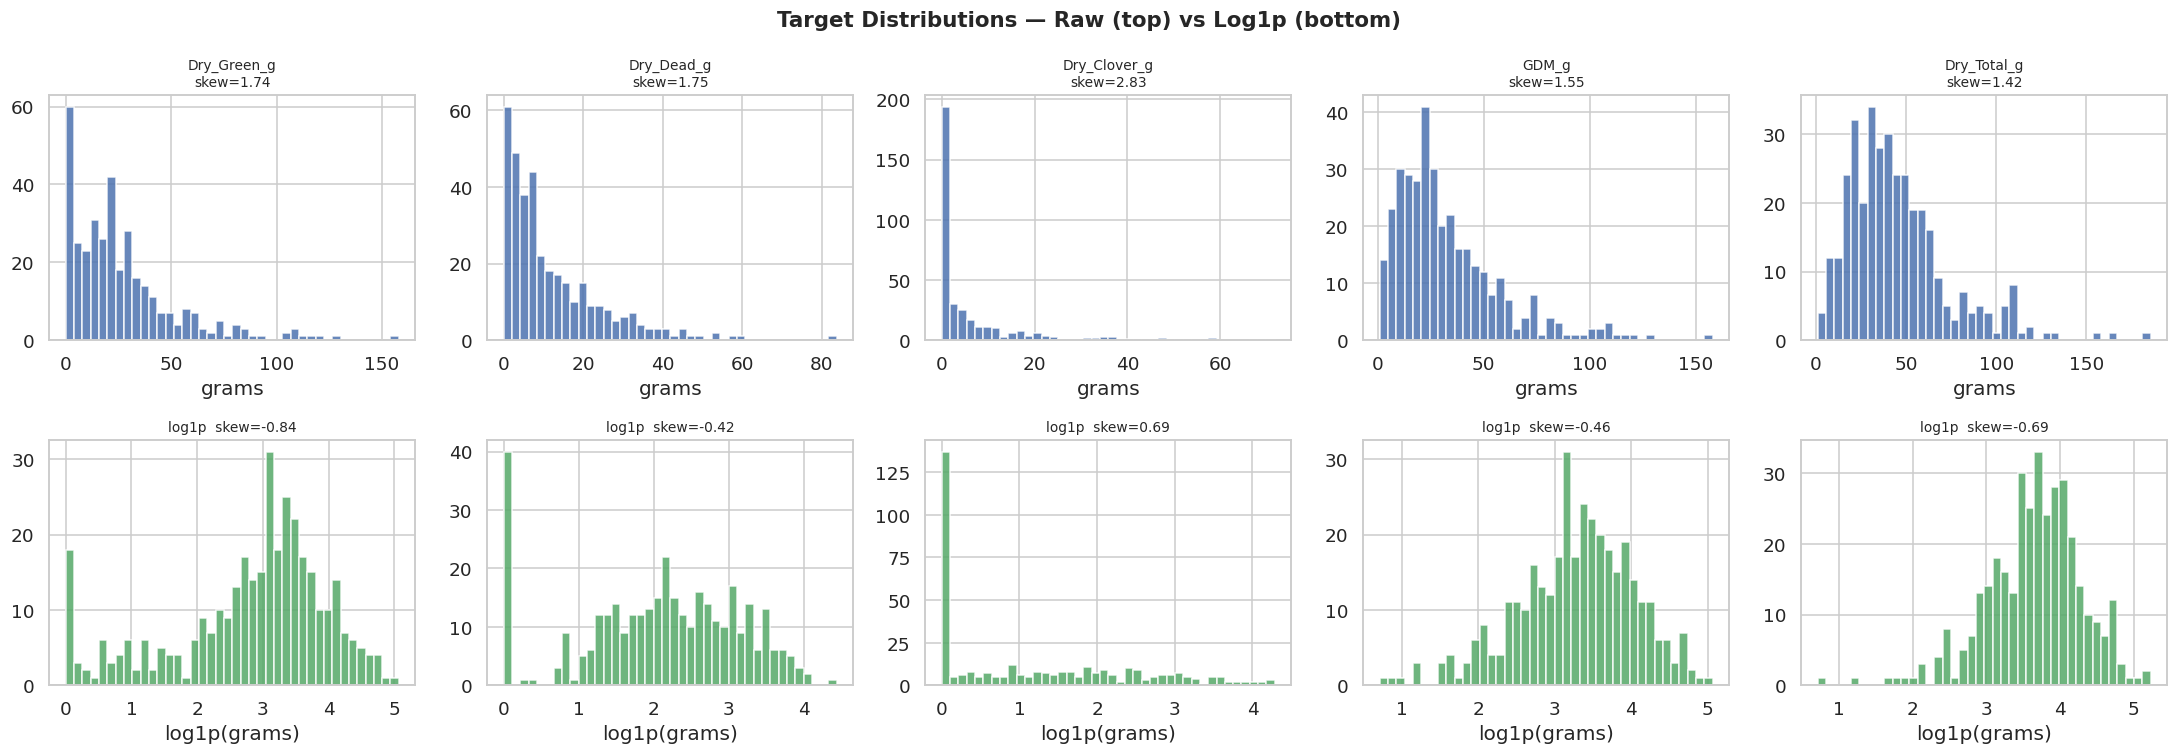

📌 If skew > 1.0 after log1p → still needs box-cox or sqrt transform
   All biomass targets are typically right-skewed (lognormal).
   Training with log1p(target) + expm1(pred) is standard practice.



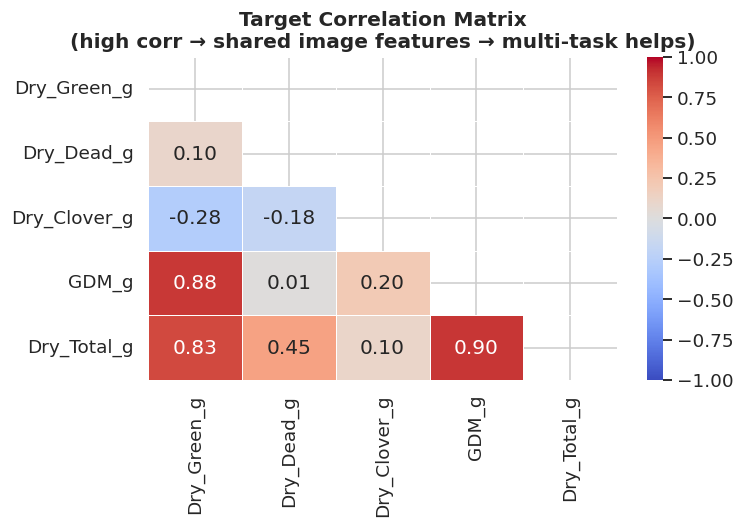

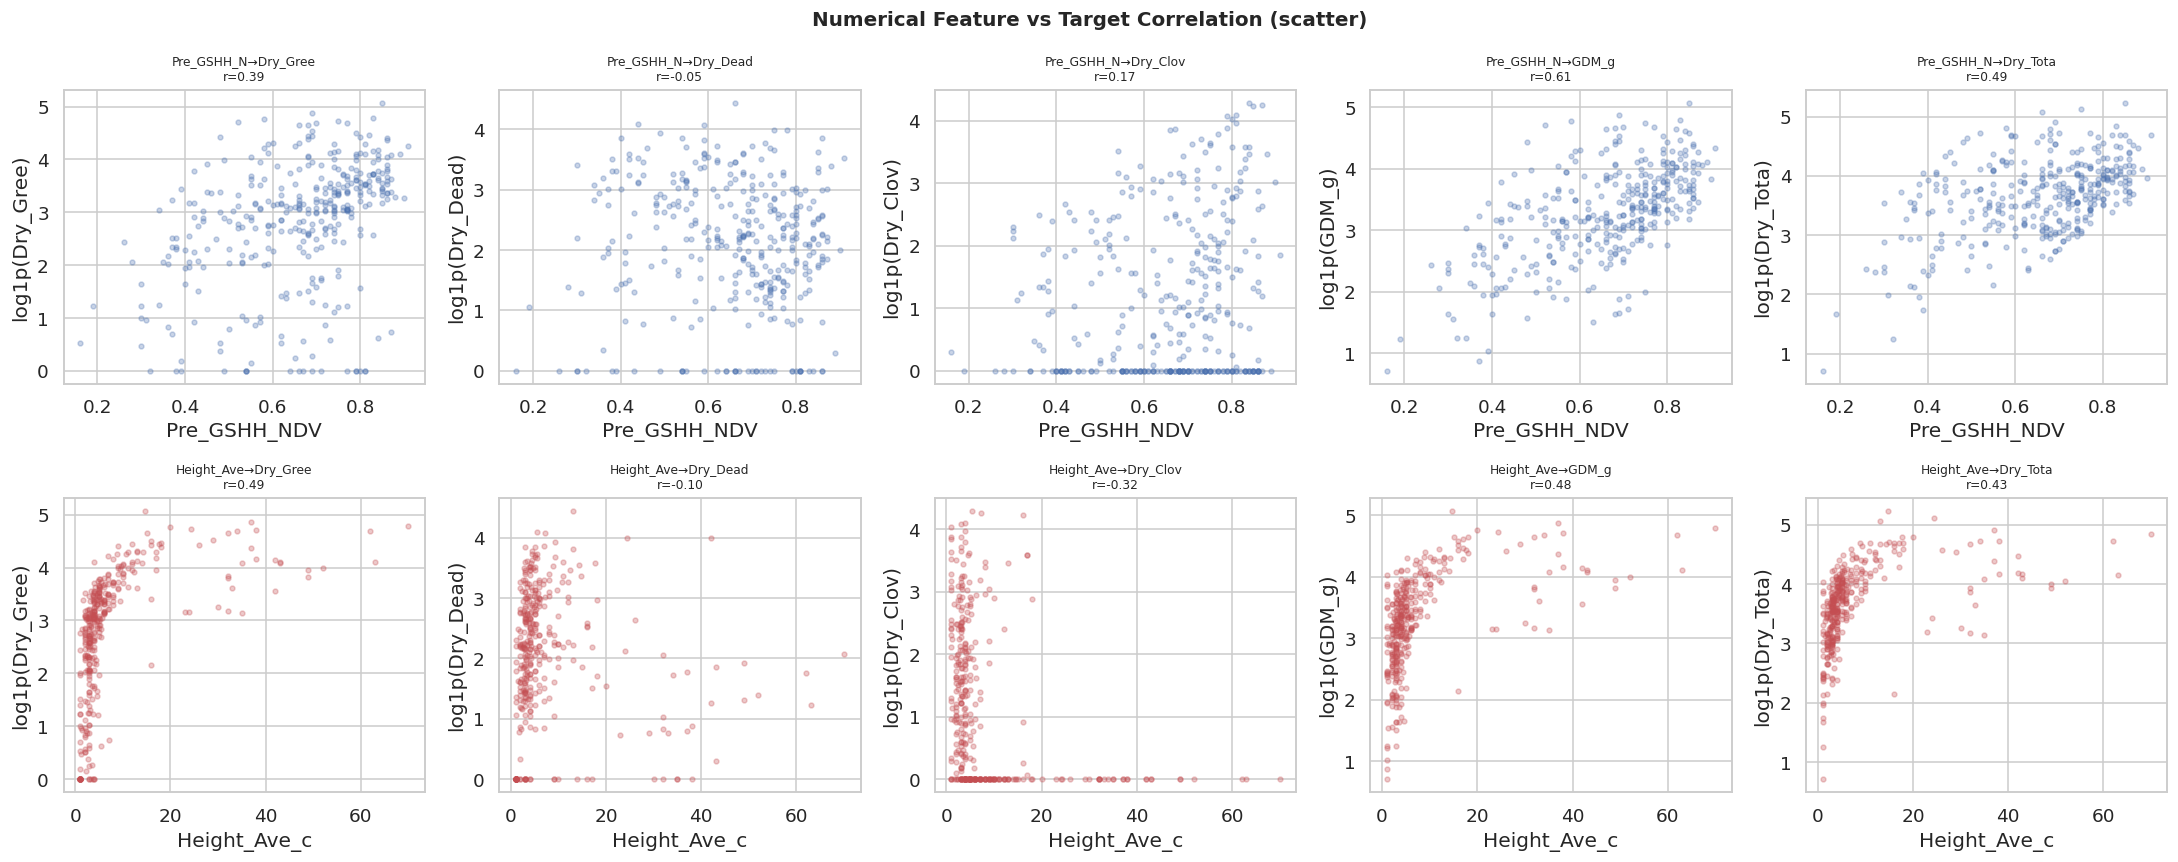

CATEGORICAL FEATURE ANALYSIS

State — 4 unique values
State
Tas    138
Vic    112
NSW     75
WA      32

Species — 13 unique values
Species
Ryegrass_Clover                                                98
Ryegrass                                                       62
Phalaris_Clover                                                42
Clover                                                         41
Fescue                                                         28
Lucerne                                                        22
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed    11
Fescue_CrumbWeed                                               10
WhiteClover                                                    10
Phalaris                                                        8
  ⚠️  2 rare categories (count<5) → risk of overfitting with OHE

Date range: 2015-01-15 00:00:00 → 2015-11-10 00:00:00
Years in train: [np.int32(2015)]
⚠️  Temporal features (month/season) likely imp

In [3]:
# ============================================================
# CELL 2 │ TARGET ANALYSIS + FEATURE ANALYSIS
# ============================================================
# This step helps us understand:
#   - Skewness → whether log transform will help (it almost always does
#     for biomass data which follows lognormal distributions)
#   - Outliers → will corrupt MSE-based losses
#   - Feature↔target correlation → validates usefulness of NDVI, Height
#   - Categorical cardinality → encoding strategy
# ============================================================

# ── Pivot to wide format for correlation analysis ──────────────────────────
# This step helps us understand inter-target relationships and
# prevents us from missing the additive structure of targets.
wide = (train_df
        .pivot_table(index="image_path",
                     columns="target_name",
                     values="target",
                     aggfunc="first")
        .reset_index())
meta_cols = ["image_path","Sampling_Date","State","Species",
             "Pre_GSHH_NDVI","Height_Ave_cm"]
meta = train_df[meta_cols].drop_duplicates("image_path")
wide = wide.merge(meta, on="image_path")

target_cols = ["Dry_Green_g","Dry_Dead_g","Dry_Clover_g","GDM_g","Dry_Total_g"]

# ── Figure 1: Target Distributions (raw vs log) ───────────────────────────
fig, axes = plt.subplots(2, 5, figsize=(20, 7))
fig.suptitle("Target Distributions — Raw (top) vs Log1p (bottom)", fontsize=14, fontweight="bold")

for i, col in enumerate(target_cols):
    vals = wide[col].dropna()
    sk   = stats.skew(vals)
    # Raw
    axes[0, i].hist(vals, bins=40, color="#4C72B0", edgecolor="white", alpha=0.85)
    axes[0, i].set_title(f"{col}\nskew={sk:.2f}", fontsize=9)
    axes[0, i].set_xlabel("grams")
    # Log1p
    log_vals = np.log1p(vals)
    sk_log   = stats.skew(log_vals)
    axes[1, i].hist(log_vals, bins=40, color="#55A868", edgecolor="white", alpha=0.85)
    axes[1, i].set_title(f"log1p  skew={sk_log:.2f}", fontsize=9)
    axes[1, i].set_xlabel("log1p(grams)")

plt.tight_layout()
plt.show()

print("📌 If skew > 1.0 after log1p → still needs box-cox or sqrt transform")
print("   All biomass targets are typically right-skewed (lognormal).")
print("   Training with log1p(target) + expm1(pred) is standard practice.\n")

# ── Figure 2: Target Correlation Matrix ───────────────────────────────────
# Helps us understand if targets share variance → multi-task learning potential
fig, ax = plt.subplots(figsize=(7, 5))
corr = wide[target_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1, linewidths=0.5, ax=ax)
ax.set_title("Target Correlation Matrix\n(high corr → shared image features → multi-task helps)", fontweight="bold")
plt.tight_layout()
plt.show()

# ── Figure 3: Feature Analysis ────────────────────────────────────────────
# This step helps us understand NDVI + Height signal strength and
# prevents us from discarding the most powerful tabular features.
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Numerical Feature vs Target Correlation (scatter)", fontsize=13, fontweight="bold")

for j, feat in enumerate(["Pre_GSHH_NDVI", "Height_Ave_cm"]):
    for i, col in enumerate(target_cols):
        ax = axes[j, i]
        valid = wide[[feat, col]].dropna()
        r, p  = stats.pearsonr(valid[feat], np.log1p(valid[col]))
        ax.scatter(valid[feat], np.log1p(valid[col]),
                   alpha=0.3, s=10, color="#4C72B0" if j==0 else "#C44E52")
        ax.set_title(f"{feat[:10]}→{col[:8]}\nr={r:.2f}", fontsize=8)
        ax.set_xlabel(feat[:12])
        ax.set_ylabel(f"log1p({col[:8]})")

plt.tight_layout()
plt.show()

# ── Categorical Analysis ───────────────────────────────────────────────────
# This step helps us understand cardinality/imbalance and
# prevents high-cardinality label encoding from leaking noise.
print("=" * 60)
print("CATEGORICAL FEATURE ANALYSIS")
print("=" * 60)

for col in ["State", "Species"]:
    vc = wide[col].value_counts()
    print(f"\n{col} — {vc.nunique()} unique values")
    print(vc.head(10).to_string())
    if vc.nunique() > 20:
        print(f"  ⚠️  HIGH CARDINALITY ({vc.nunique()}) → use target encoding or embeddings")
    rare = (vc < 5).sum()
    if rare > 0:
        print(f"  ⚠️  {rare} rare categories (count<5) → risk of overfitting with OHE")

# ── Sampling Date Analysis ─────────────────────────────────────────────────
wide["Sampling_Date"] = pd.to_datetime(wide["Sampling_Date"])
wide["month"]  = wide["Sampling_Date"].dt.month
wide["year"]   = wide["Sampling_Date"].dt.year
print(f"\nDate range: {wide['Sampling_Date'].min()} → {wide['Sampling_Date'].max()}")
print(f"Years in train: {sorted(wide['year'].unique())}")
print("⚠️  Temporal features (month/season) likely important for biomass growth cycles.")

🔍 LEAKAGE RISK CHECK

1. sample_id      → Pure ID, NO predictive value. Drop it.
2. image_path     → Contains image ID only. Safe to use as grouping key.
3. Height_Ave_cm  → MODERATE LEAKAGE RISK.
   Falling plate height IS correlated with total biomass by definition.
   This feature is available at inference time (farmer measures it),
   so it is NOT post-event leakage. It's a valid feature.
   ✅ Keep but monitor: if model leans 100% on height, it's not learning vision.

4. Pre_GSHH_NDVI  → NDVI is measured BEFORE the sample ('Pre_'). Safe.
   ✅ Keep. Strong agronomic signal.

5. Sampling_Date  → This is the ground-truth collection date.
   If test images come from dates AFTER train → temporal shift.
   If test images are from same time period → safe.
   ⚠️  Check overlap below.

6. Species        → Known at measurement time. Safe feature.
   ✅ Keep. Species dramatically affects biomass composition.

CONCLUSION: No hard leakage detected. Height_Ave_cm is the
highest-risk feature but i

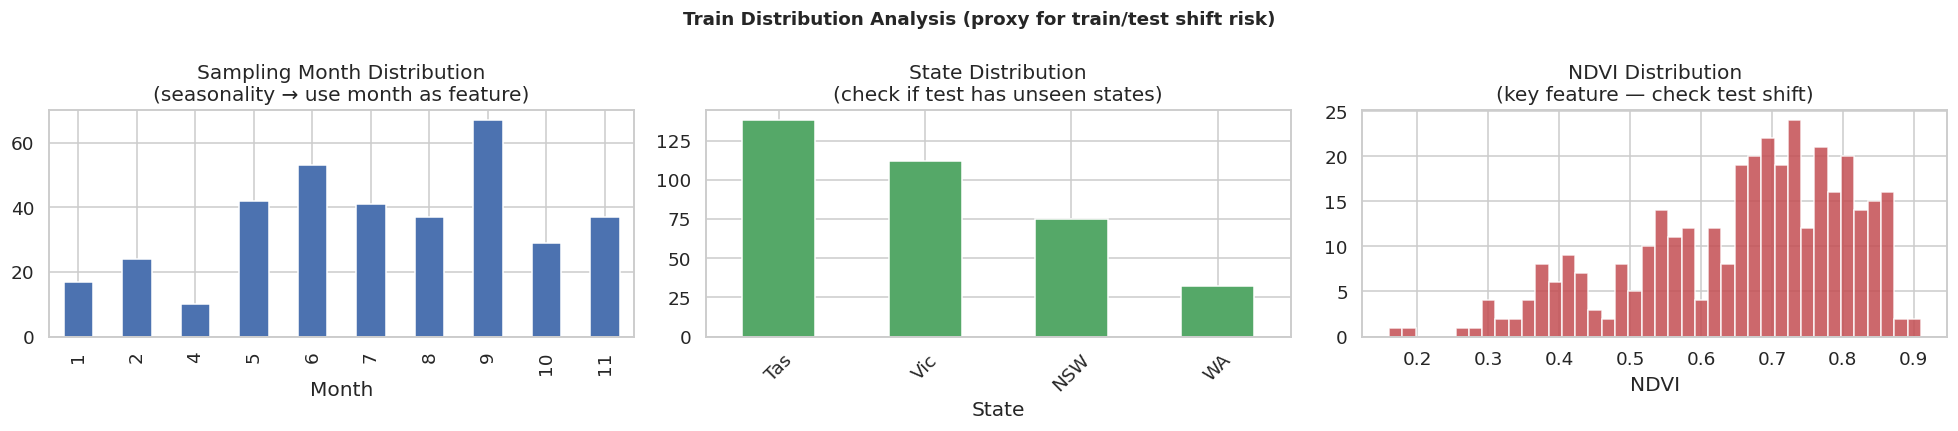

📊 RARE VALUE / TAIL ANALYSIS (Regression Imbalance)
Dry_Green_g     | median=    20.8g | p95=    80.1g | p99=   114.6g | extreme(>p99)=4
Dry_Dead_g      | median=     8.0g | p95=    36.2g | p99=    53.1g | extreme(>p99)=4
Dry_Clover_g    | median=     1.4g | p95=    33.1g | p99=    58.6g | extreme(>p99)=4
GDM_g           | median=    27.1g | p95=    83.1g | p99=   114.6g | extreme(>p99)=4
Dry_Total_g     | median=    40.3g | p95=   105.4g | p99=   129.9g | extreme(>p99)=4

⚠️  HIGH-VALUE OUTLIERS are common in biomass data (dense pastures).
    These hurt MSE loss but are real samples.
    Strategy: Train on log1p(target), which naturally compresses extremes.
    Alternative: Huber loss (robust to outliers).
    DO NOT clip/remove outliers — they're valid agricultural measurements.

── Sample Image Grid ──


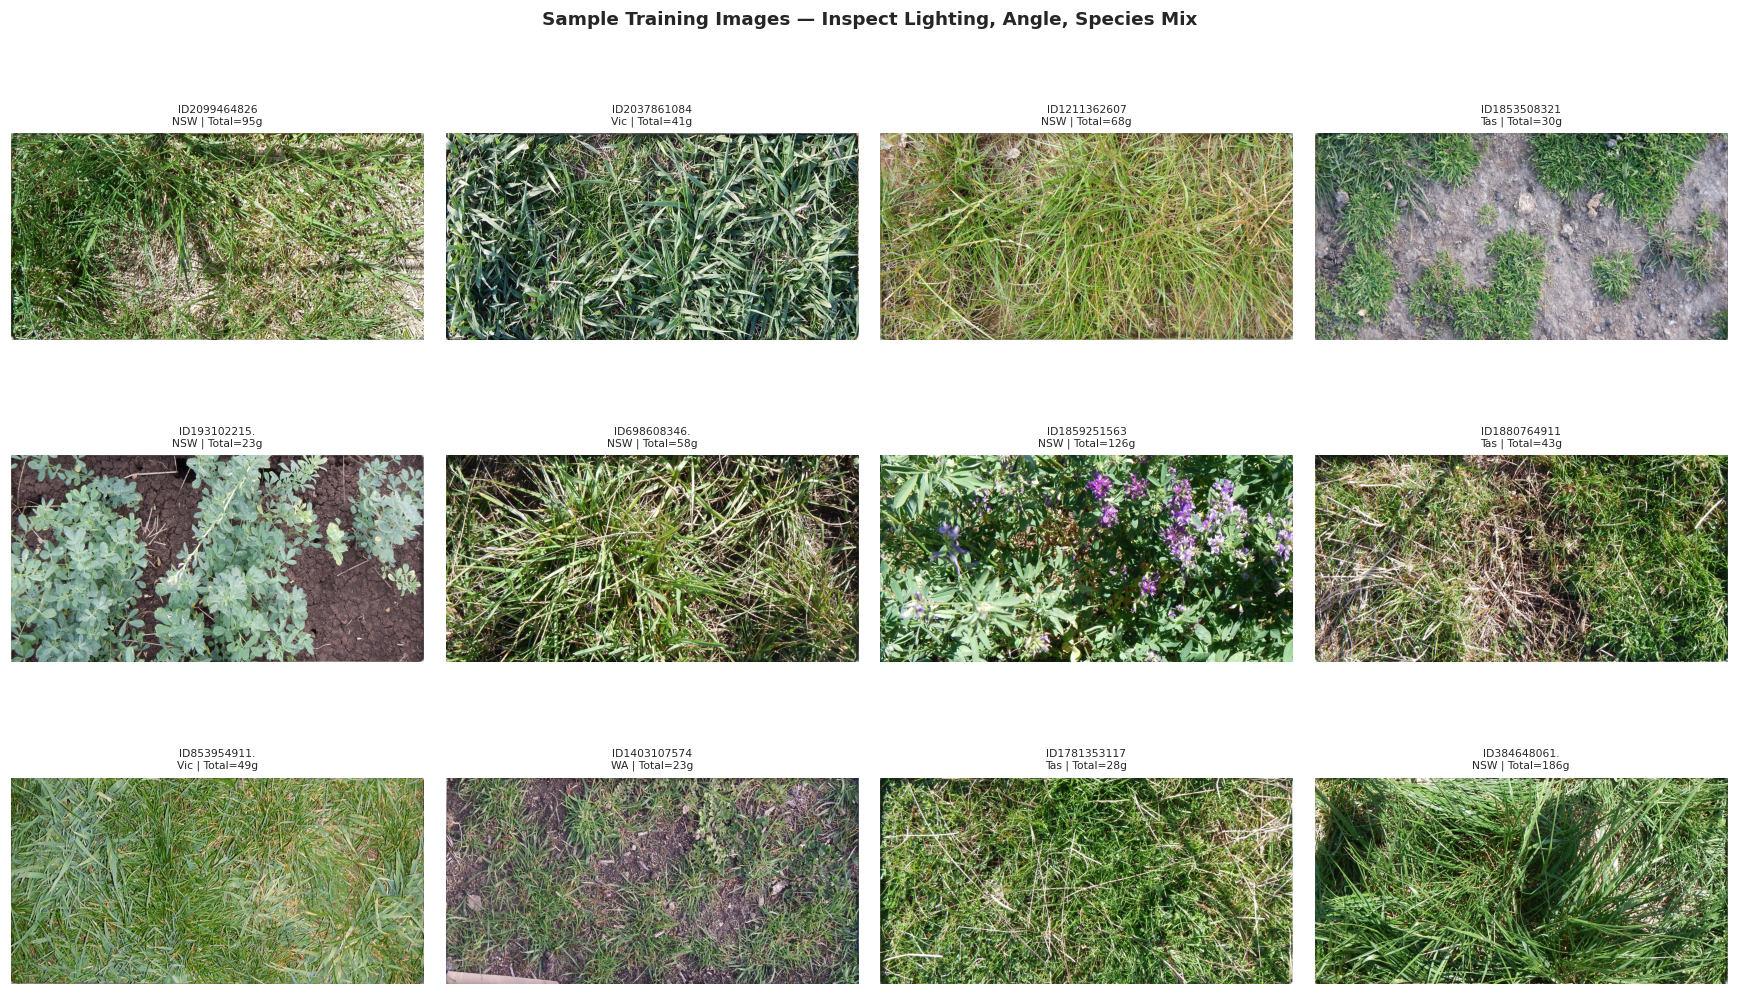

In [4]:
# ============================================================
# CELL 3 │ LEAKAGE CHECK + TRAIN/TEST DISTRIBUTION SHIFT
# ============================================================
# This step helps us understand data drift between train and test
# and prevents optimistic CV scores that don't generalize.
# Also checks for any accidental leakage sources.
# ============================================================

# ── Leakage Risk Assessment ────────────────────────────────────────────────
print("=" * 60)
print("🔍 LEAKAGE RISK CHECK")
print("=" * 60)

print("""
1. sample_id      → Pure ID, NO predictive value. Drop it.
2. image_path     → Contains image ID only. Safe to use as grouping key.
3. Height_Ave_cm  → MODERATE LEAKAGE RISK.
   Falling plate height IS correlated with total biomass by definition.
   This feature is available at inference time (farmer measures it),
   so it is NOT post-event leakage. It's a valid feature.
   ✅ Keep but monitor: if model leans 100% on height, it's not learning vision.

4. Pre_GSHH_NDVI  → NDVI is measured BEFORE the sample ('Pre_'). Safe.
   ✅ Keep. Strong agronomic signal.

5. Sampling_Date  → This is the ground-truth collection date.
   If test images come from dates AFTER train → temporal shift.
   If test images are from same time period → safe.
   ⚠️  Check overlap below.

6. Species        → Known at measurement time. Safe feature.
   ✅ Keep. Species dramatically affects biomass composition.

CONCLUSION: No hard leakage detected. Height_Ave_cm is the
highest-risk feature but it's a legitimate measurement.
""")

# ── Check date overlap between train images vs test ───────────────────────
# Test.csv has no date column, but we can check train temporal coverage.
wide["Sampling_Date"] = pd.to_datetime(wide["Sampling_Date"])

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle("Train Distribution Analysis (proxy for train/test shift risk)", fontsize=12, fontweight="bold")

# Monthly distribution (seasonality signal)
wide["month"].value_counts().sort_index().plot(kind="bar", ax=axes[0],
    color="#4C72B0", edgecolor="white")
axes[0].set_title("Sampling Month Distribution\n(seasonality → use month as feature)")
axes[0].set_xlabel("Month")

# State distribution
wide["State"].value_counts().plot(kind="bar", ax=axes[1],
    color="#55A868", edgecolor="white")
axes[1].set_title("State Distribution\n(check if test has unseen states)")
axes[1].set_xlabel("State")
axes[1].tick_params(axis='x', rotation=45)

# NDVI distribution
axes[2].hist(wide["Pre_GSHH_NDVI"].dropna(), bins=40,
             color="#C44E52", edgecolor="white", alpha=0.85)
axes[2].set_title("NDVI Distribution\n(key feature — check test shift)")
axes[2].set_xlabel("NDVI")

plt.tight_layout()
plt.show()

# ── Rare Value / Imbalance in Regression ──────────────────────────────────
print("=" * 60)
print("📊 RARE VALUE / TAIL ANALYSIS (Regression Imbalance)")
print("=" * 60)

for col in target_cols:
    vals = wide[col].dropna()
    p95  = np.percentile(vals, 95)
    p99  = np.percentile(vals, 99)
    n_extreme = (vals > p99).sum()
    print(f"{col:<15} | median={vals.median():>8.1f}g | p95={p95:>8.1f}g | "
          f"p99={p99:>8.1f}g | extreme(>p99)={n_extreme}")

print("""
⚠️  HIGH-VALUE OUTLIERS are common in biomass data (dense pastures).
    These hurt MSE loss but are real samples.
    Strategy: Train on log1p(target), which naturally compresses extremes.
    Alternative: Huber loss (robust to outliers).
    DO NOT clip/remove outliers — they're valid agricultural measurements.
""")

# ── Image Sample Inspection ────────────────────────────────────────────────
# This step helps us understand image quality/variability and
# prevents us from applying wrong augmentations (e.g. heavy colour jitter
# on images that already vary wildly in lighting).
print("── Sample Image Grid ──")
img_paths = list(TRAIN_DIR.glob("*.jpg"))[:12]

if len(img_paths) > 0:
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    fig.suptitle("Sample Training Images — Inspect Lighting, Angle, Species Mix",
                 fontsize=12, fontweight="bold")
    for ax, p in zip(axes.flat, img_paths):
        img = Image.open(p)
        ax.imshow(img)
        # Get target info for this image
        img_key = "train/" + p.name
        row = train_df[train_df["image_path"].str.endswith(p.name)]
        if len(row):
            total = row[row["target_name"]=="Dry_Total_g"]["target"].values
            label = f"{p.name[:12]}\n{row['State'].values[0]} | Total={total[0]:.0f}g" if len(total) else p.name[:12]
        else:
            label = p.name[:12]
        ax.set_title(label, fontsize=7)
        ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No images found at path — adjust TRAIN_DIR if needed.")

1️⃣ Multi-Output + Structural Dependency

Takeaway:
Targets dependent:

GDM = Green + Clover

Total = GDM + Dead
Total = 50% score.

Solution:
✔ Predict only Green, Clover, Dead
✔ Derive GDM & Total
✔ Maintain structural consistency

2️⃣ Targets are Right-Skewed

Takeaway:
Heavy tail, extreme high biomass values.

Solution:
✔ Train on log1p(target)
✔ Predict → expm1()
✔ Optional: Huber loss
❌ Don’t remove outliers

3️⃣ Small Dataset (357 images)

Takeaway:
High overfitting risk.

Solution:
✔ Use GroupKFold (by sample_id)
✔ Use LightGBM / CatBoost
❌ No deep model from scratch

4️⃣ Height is Strong Feature

Takeaway:
Highly correlated with biomass.

Solution:
✔ Keep it
✔ Log-transform if skewed
✔ Monitor feature importance

5️⃣ NDVI is Strong Agronomic Signal

Takeaway:
Likely predictive.

Solution:
✔ Keep
✔ Check correlation

6️⃣ Rare Species Risk

Takeaway:
Some categories very small → overfitting risk.

Solution:
✔ Group rare → “Other”
OR
✔ Use CatBoost

7️⃣ Temporal Signal Exists

Takeaway:
Biomass seasonal.

Solution:
✔ Extract month
✔ Add season feature

8️⃣ Leakage

Takeaway:
No hard leakage.
Risk only if splitting wrong.

Solution:
✔ Split by sample_id (GroupKFold)

## the dirn :-
Problem type identify kiya (multi-output regression)

Metric samjha (weighted R²)

Target dependency pakdi (structural identity) → this is advanced thinking

Skew detect kiya → log transform plan

Leakage check kiya

Rare category risk identify kiya

Group-based split samjha

Modeling strategy design kar rahe ho before training

In [5]:
# ============================================================
# CELL 4 │ BASELINE PLAN + VALIDATION STRATEGY + METRIC IMPL
# ============================================================
# This step documents the full competition attack plan and
# implements the exact evaluation metric so CV scores match LB.
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

# ── Implement the EXACT Competition Metric ────────────────────────────────
# WHY: Never trust generic R² — the weighted global R² is different.
# This prevents overconfident CV scores that don't match the leaderboard.

WEIGHTS = {
    "Dry_Green_g": 0.10, "Dry_Dead_g": 0.10, "Dry_Clover_g": 0.10,
    "GDM_g": 0.20,       "Dry_Total_g": 0.50
}

def weighted_r2(y_true: np.ndarray,
                y_pred: np.ndarray,
                target_names: np.ndarray) -> float:
    """
    Compute the globally weighted R² as defined by CSIRO competition.
    All rows are pooled together; each row weighted by its target type.
    """
    w = np.array([WEIGHTS[t] for t in target_names])
    w_mean = np.sum(w * y_true) / np.sum(w)          # weighted global mean
    ss_res = np.sum(w * (y_true - y_pred) ** 2)
    ss_tot = np.sum(w * (y_true - w_mean) ** 2)
    return 1.0 - ss_res / ss_tot

# Sanity check — predicting weighted mean should give R²=0
train_df_load = pd.read_csv("/kaggle/input/competitions/csiro-biomass/train.csv")
y_true   = train_df_load["target"].values
t_names  = train_df_load["target_name"].values
w_arr    = np.array([WEIGHTS[t] for t in t_names])
w_mean   = np.sum(w_arr * y_true) / np.sum(w_arr)
baseline_pred = np.full_like(y_true, w_mean, dtype=float)
print(f"Baseline R² (predict weighted mean) = {weighted_r2(y_true, baseline_pred, t_names):.6f}")
print("Expected: ~0.0  ✅\n")

# ── Validation Strategy ────────────────────────────────────────────────────
print("=" * 65)
print("VALIDATION STRATEGY")
print("=" * 65)
print("""
USE: GroupKFold(n_splits=5) with groups = image_path

WHY GroupKFold?
  Each image has 5 rows (one per target). A random KFold would put
  different targets of the SAME image in train and val → data leakage!
  GroupKFold ensures all 5 rows of an image are either ALL in train
  or ALL in val. This gives honest, leak-free CV.

WHY 5 Folds?
  ~800 images → 5-fold = ~640 train / ~160 val per fold.
  Enough val data to estimate weighted R² stably.

CONSIDER: StratifiedGroupKFold on target value bins if distribution
  is very uneven (check with pd.qcut on Dry_Total_g).
""")

# Demonstrate GroupKFold setup
gkf    = GroupKFold(n_splits=5)
groups = train_df_load["image_path"].values

fold_sizes = []
for fold, (tr_idx, val_idx) in enumerate(gkf.split(train_df_load, groups=groups)):
    n_train_img = len(np.unique(groups[tr_idx]))
    n_val_img   = len(np.unique(groups[val_idx]))
    fold_sizes.append((n_train_img, n_val_img))
    print(f"  Fold {fold+1}: {n_train_img} train images | {n_val_img} val images")

# ── Full Attack Plan ───────────────────────────────────────────────────────
print("\n" + "=" * 65)
print("🏆 COMPETITION ATTACK PLAN (Priority Order)")
print("=" * 65)

plan = """
PHASE 1 — STRONG BASELINE (target: positive LB score)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Model    : EfficientNet-B3 or ConvNeXt-Tiny (pretrained ImageNet)
  Targets  : Predict all 5 targets simultaneously (multi-task head)
  Loss     : MSE on log1p(target) — handles skew + scale differences
  Tabular  : Concatenate [NDVI, Height, month_sin, month_cos, State_emb]
             to the CNN's global avg pool feature vector
  Output   : 5-head linear layer → expm1() at inference
  Augment  : RandomHFlip, RandomCrop, ColorJitter(mild), RandomRotate
  Scheduler: CosineAnnealing with warmup
  CV Score : GroupKFold-5 weighted R²

PHASE 2 — FEATURE ENGINEERING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • month_sin/cos  → captures seasonality continuously
  • is_clover_dominant  → from Species string parsing
  • NDVI × Height  → interaction term (both measure greenness)
  • State + Season interaction → regional growth patterns
  • primary_species  → first underscore token of Species col

PHASE 3 — STRUCTURAL CONSTRAINT (score booster)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  After prediction, enforce:
    GDM_g_adj       = Dry_Green_g_pred + Dry_Clover_g_pred
    Dry_Total_g_adj = GDM_g_adj + Dry_Dead_g_pred
  Post-processing blend: 0.7 * model_pred + 0.3 * constraint_pred
  This helps the 50%-weighted Dry_Total_g specifically.

PHASE 4 — ENSEMBLE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • EfficientNet-B3 + EfficientNet-B4 + ConvNeXt-Tiny
  • TTA: original + hflip average
  • Optionally: XGBoost on tabular-only as a blend component

PHASE 5 — FINAL TUNING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Up-weight Dry_Total_g in loss to match competition weights:
      loss = 0.5*MSE(total) + 0.2*MSE(gdm) + 0.1*MSE(others×3)
  • Larger backbone (EfficientNet-B5 / Swin-T) if compute allows
  • Pseudo-labeling on test if score plateaus
"""
print(plan)

print("=" * 65)
print("🎯 QUICK WINS SUMMARY")
print("=" * 65)
print("""
  1. log1p transform on targets         → fixes skew, stabilises training
  2. GroupKFold on image_path           → prevents leakage in CV
  3. Multi-task head (5 outputs)        → shared image features help all targets
  4. Structural constraint enforcement  → free score on Dry_Total_g
  5. NDVI + Height as tabular fusion    → strong agronomic signal
  6. Month sin/cos encoding             → seasonal growth cycle
  7. Weight loss by competition weights → directly optimizes the metric
""")

Baseline R² (predict weighted mean) = 0.000000
Expected: ~0.0  ✅

VALIDATION STRATEGY

USE: GroupKFold(n_splits=5) with groups = image_path

WHY GroupKFold?
  Each image has 5 rows (one per target). A random KFold would put
  different targets of the SAME image in train and val → data leakage!
  GroupKFold ensures all 5 rows of an image are either ALL in train
  or ALL in val. This gives honest, leak-free CV.

WHY 5 Folds?
  ~800 images → 5-fold = ~640 train / ~160 val per fold.
  Enough val data to estimate weighted R² stably.

CONSIDER: StratifiedGroupKFold on target value bins if distribution
  is very uneven (check with pd.qcut on Dry_Total_g).

  Fold 1: 285 train images | 72 val images
  Fold 2: 285 train images | 72 val images
  Fold 3: 286 train images | 71 val images
  Fold 4: 286 train images | 71 val images
  Fold 5: 286 train images | 71 val images

🏆 COMPETITION ATTACK PLAN (Priority Order)

PHASE 1 — STRONG BASELINE (target: positive LB score)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━

STRUCTURAL IDENTITY VERIFICATION
Claim 1: GDM_g       ≈ Dry_Green_g + Dry_Clover_g
Claim 2: Dry_Total_g ≈ GDM_g + Dry_Dead_g

Identity 1 — GDM = Green + Clover
  Mean absolute residual : 0.00 g
  Median % error         : 0.00%
  Rows with >10% error   : 0 / 357
  Rows with >50% error   : 0 / 357

Identity 2 — Total = GDM + Dead
  Mean absolute residual : 0.00 g
  Median % error         : 0.00%
  Rows with >10% error   : 0 / 357
  Rows with >50% error   : 0 / 357

🔑 DECISION:
  ✅ Both identities hold tightly (<5% error).
     → SAFE to use constraint post-processing as score booster.


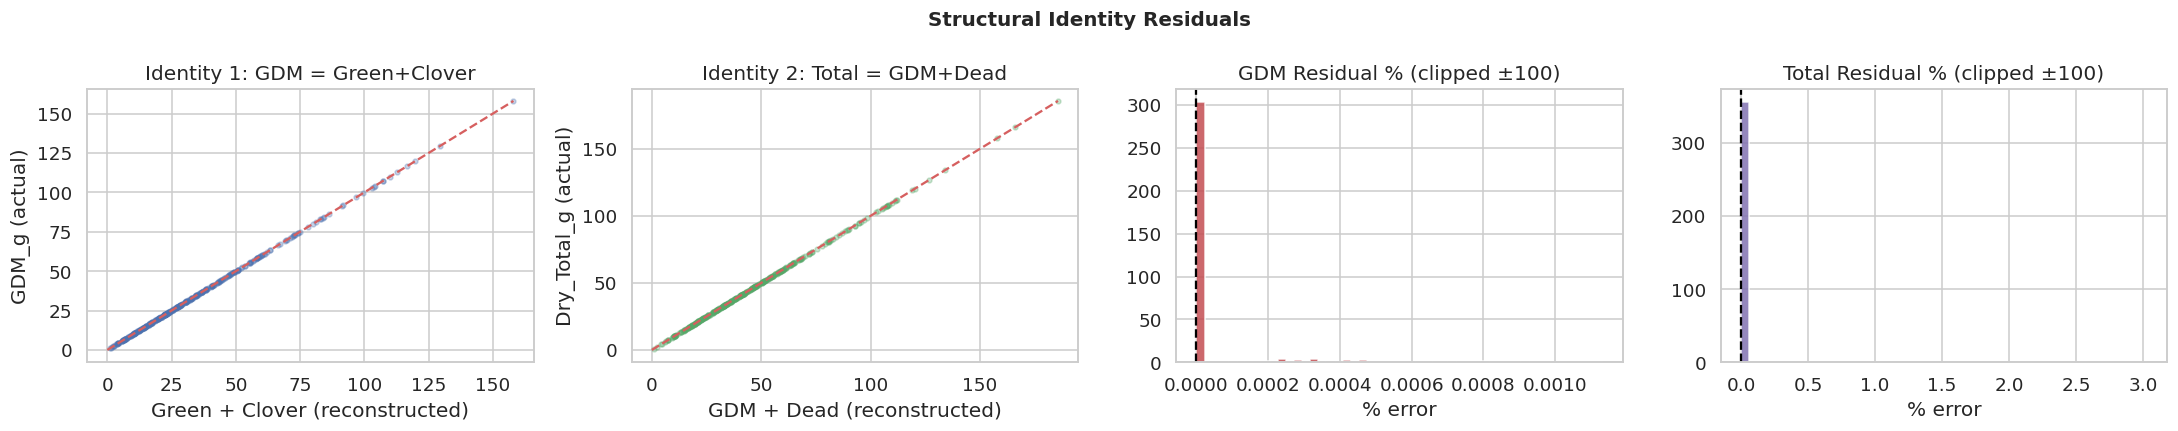


OUTLIER SEVERITY ANALYSIS → Decides: MSE vs Huber vs MAE
Dry_Green_g     | skew= 1.74 | max/median=   7.6x | extreme(3×IQR)=  4 | → MSE likely fine
Dry_Dead_g      | skew= 1.75 | max/median=  10.5x | extreme(3×IQR)=  1 | → Huber/log loss recommended
Dry_Clover_g    | skew= 2.83 | max/median=  50.4x | extreme(3×IQR)= 23 | → Huber/log loss recommended
GDM_g           | skew= 1.55 | max/median=   5.8x | extreme(3×IQR)=  2 | → MSE likely fine
Dry_Total_g     | skew= 1.42 | max/median=   4.6x | extreme(3×IQR)=  3 | → MSE likely fine


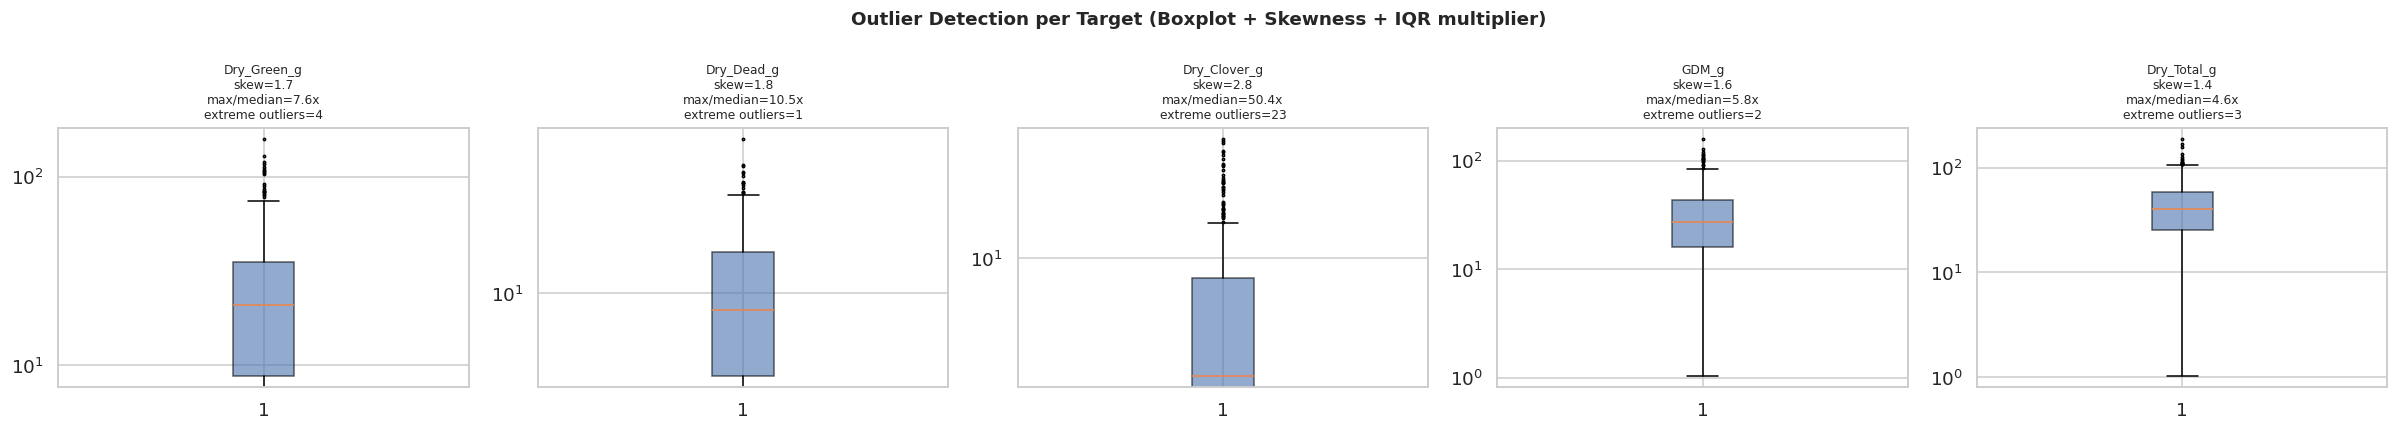


LOSS FUNCTION DECISION GUIDE:
  max/median < 5x  AND skew < 1.5  → MSE on raw target is fine
  max/median 5–15x OR  skew 1.5–3  → log1p transform + MSE  ✅ recommended
  max/median > 15x OR  skew > 3    → Huber loss OR log1p + MSE

Skewness (raw vs log1p):
Target            Skew_raw   Skew_log1p    Transform needed?
------------------------------------------------------------
Dry_Green_g          1.744       -0.837          YES → log1p
Dry_Dead_g           1.754       -0.424          YES → log1p
Dry_Clover_g         2.830        0.687          YES → log1p
GDM_g                1.552       -0.464          YES → log1p
Dry_Total_g          1.423       -0.688          YES → log1p


In [6]:
# ============================================================
# CELL 5 │ STRUCTURAL IDENTITY CHECK + OUTLIER DEEP DIVE
# ============================================================
# This step helps us understand whether the additive constraint
# (Total = GDM + Dead, GDM = Green + Clover) actually holds in data.
# If it doesn't hold → constraint post-processing will HURT the score.
# Also quantifies outlier severity to decide loss function choice.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

ROOT     = Path("/kaggle/input/competitions/csiro-biomass")
train_df = pd.read_csv(ROOT / "train.csv")

# ── Pivot to wide format ───────────────────────────────────────────────────
wide = (train_df
        .pivot_table(index="image_path",
                     columns="target_name",
                     values="target",
                     aggfunc="first")
        .reset_index())

meta = train_df[["image_path","Pre_GSHH_NDVI","Height_Ave_cm",
                 "Sampling_Date","State","Species"]].drop_duplicates("image_path")
wide = wide.merge(meta, on="image_path")

target_cols = ["Dry_Green_g","Dry_Dead_g","Dry_Clover_g","GDM_g","Dry_Total_g"]

# ══════════════════════════════════════════════════════════════
# PART A: STRUCTURAL IDENTITY VERIFICATION
# ══════════════════════════════════════════════════════════════
print("=" * 65)
print("STRUCTURAL IDENTITY VERIFICATION")
print("Claim 1: GDM_g       ≈ Dry_Green_g + Dry_Clover_g")
print("Claim 2: Dry_Total_g ≈ GDM_g + Dry_Dead_g")
print("=" * 65)

# Identity 1
wide["GDM_reconstructed"]   = wide["Dry_Green_g"] + wide["Dry_Clover_g"]
wide["GDM_residual"]        = wide["GDM_g"] - wide["GDM_reconstructed"]
wide["GDM_residual_pct"]    = (wide["GDM_residual"].abs() / wide["GDM_g"].clip(1)) * 100

# Identity 2
wide["Total_reconstructed"] = wide["GDM_g"] + wide["Dry_Dead_g"]
wide["Total_residual"]      = wide["Dry_Total_g"] - wide["Total_reconstructed"]
wide["Total_residual_pct"]  = (wide["Total_residual"].abs() / wide["Dry_Total_g"].clip(1)) * 100

print(f"\nIdentity 1 — GDM = Green + Clover")
print(f"  Mean absolute residual : {wide['GDM_residual'].abs().mean():.2f} g")
print(f"  Median % error         : {wide['GDM_residual_pct'].median():.2f}%")
print(f"  Rows with >10% error   : {(wide['GDM_residual_pct'] > 10).sum()} / {len(wide)}")
print(f"  Rows with >50% error   : {(wide['GDM_residual_pct'] > 50).sum()} / {len(wide)}")

print(f"\nIdentity 2 — Total = GDM + Dead")
print(f"  Mean absolute residual : {wide['Total_residual'].abs().mean():.2f} g")
print(f"  Median % error         : {wide['Total_residual_pct'].median():.2f}%")
print(f"  Rows with >10% error   : {(wide['Total_residual_pct'] > 10).sum()} / {len(wide)}")
print(f"  Rows with >50% error   : {(wide['Total_residual_pct'] > 50).sum()} / {len(wide)}")

# ── Decision Rule ──────────────────────────────────────────────────────────
gdm_median_err   = wide["GDM_residual_pct"].median()
total_median_err = wide["Total_residual_pct"].median()

print("\n🔑 DECISION:")
if gdm_median_err < 5 and total_median_err < 5:
    print("  ✅ Both identities hold tightly (<5% error).")
    print("     → SAFE to use constraint post-processing as score booster.")
elif gdm_median_err < 15 and total_median_err < 15:
    print("  ⚠️  Identities hold approximately (5–15% error).")
    print("     → Use constraint with LOW blend weight (0.1–0.2), not hard enforcement.")
else:
    print("  ❌ Identities DO NOT hold reliably (>15% median error).")
    print("     → DROP the constraint trick entirely. It will hurt your score.")

# ── Visualise Identity Residuals ──────────────────────────────────────────
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
fig.suptitle("Structural Identity Residuals", fontsize=13, fontweight="bold")

# Scatter: actual vs reconstructed GDM
axes[0].scatter(wide["GDM_reconstructed"], wide["GDM_g"],
                alpha=0.3, s=10, color="#4C72B0")
lim = max(wide["GDM_g"].max(), wide["GDM_reconstructed"].max())
axes[0].plot([0, lim], [0, lim], "r--", lw=1.5)
axes[0].set_xlabel("Green + Clover (reconstructed)"); axes[0].set_ylabel("GDM_g (actual)")
axes[0].set_title("Identity 1: GDM = Green+Clover")

# Scatter: actual vs reconstructed Total
axes[1].scatter(wide["Total_reconstructed"], wide["Dry_Total_g"],
                alpha=0.3, s=10, color="#55A868")
lim = max(wide["Dry_Total_g"].max(), wide["Total_reconstructed"].max())
axes[1].plot([0, lim], [0, lim], "r--", lw=1.5)
axes[1].set_xlabel("GDM + Dead (reconstructed)"); axes[1].set_ylabel("Dry_Total_g (actual)")
axes[1].set_title("Identity 2: Total = GDM+Dead")

# Residual % histogram — GDM
axes[2].hist(wide["GDM_residual_pct"].clip(-100, 100), bins=50,
             color="#C44E52", edgecolor="white", alpha=0.85)
axes[2].axvline(0, color="black", lw=1.5, ls="--")
axes[2].set_title("GDM Residual % (clipped ±100)")
axes[2].set_xlabel("% error")

# Residual % histogram — Total
axes[3].hist(wide["Total_residual_pct"].clip(-100, 100), bins=50,
             color="#8172B2", edgecolor="white", alpha=0.85)
axes[3].axvline(0, color="black", lw=1.5, ls="--")
axes[3].set_title("Total Residual % (clipped ±100)")
axes[3].set_xlabel("% error")

plt.tight_layout()
plt.show()

# ══════════════════════════════════════════════════════════════
# PART B: OUTLIER SEVERITY — decides loss function
# ══════════════════════════════════════════════════════════════
print("\n" + "=" * 65)
print("OUTLIER SEVERITY ANALYSIS → Decides: MSE vs Huber vs MAE")
print("=" * 65)

fig, axes = plt.subplots(1, 5, figsize=(22, 4))
fig.suptitle("Outlier Detection per Target (Boxplot + Skewness + IQR multiplier)",
             fontsize=12, fontweight="bold")

for i, col in enumerate(target_cols):
    vals   = wide[col].dropna()
    q1, q3 = vals.quantile(0.25), vals.quantile(0.75)
    iqr    = q3 - q1
    upper  = q3 + 3 * iqr     # 3×IQR = extreme outlier threshold
    n_out  = (vals > upper).sum()
    ratio  = vals.max() / vals.median() if vals.median() > 0 else np.nan
    skew   = stats.skew(vals)

    axes[i].boxplot(vals, vert=True, patch_artist=True,
                    boxprops=dict(facecolor="#4C72B0", alpha=0.6),
                    flierprops=dict(marker=".", markersize=3, color="red"))
    axes[i].set_title(
        f"{col}\nskew={skew:.1f}\nmax/median={ratio:.1f}x\n"
        f"extreme outliers={n_out}", fontsize=8)
    axes[i].set_yscale("log")   # log scale to see full range

    print(f"{col:<15} | skew={skew:>5.2f} | max/median={ratio:>6.1f}x "
          f"| extreme(3×IQR)={n_out:>3d} | "
          f"{'→ Huber/log loss recommended' if ratio > 10 else '→ MSE likely fine'}")

plt.tight_layout()
plt.show()

print("""
LOSS FUNCTION DECISION GUIDE:
  max/median < 5x  AND skew < 1.5  → MSE on raw target is fine
  max/median 5–15x OR  skew 1.5–3  → log1p transform + MSE  ✅ recommended
  max/median > 15x OR  skew > 3    → Huber loss OR log1p + MSE
""")

# ── Skewness numbers ──────────────────────────────────────────────────────
print("Skewness (raw vs log1p):")
print(f"{'Target':<15} {'Skew_raw':>10} {'Skew_log1p':>12} {'Transform needed?':>20}")
print("-" * 60)
for col in target_cols:
    vals    = wide[col].dropna()
    s_raw   = stats.skew(vals)
    s_log   = stats.skew(np.log1p(vals))
    needed  = "YES → log1p" if abs(s_raw) > 1.0 else "No"
    print(f"{col:<15} {s_raw:>10.3f} {s_log:>12.3f} {needed:>20}")

Train on log1p(base_targets)
Loss = MSE
Validation = Weighted R² on original scale

MISSING DATA AUDIT — Does test have tabular metadata?

── Train missing values (image level) ──
  Pre_GSHH_NDVI        missing=   0 (  0.0%)  🟢 OK
  Height_Ave_cm        missing=   0 (  0.0%)  🟢 OK
  State                missing=   0 (  0.0%)  🟢 OK
  Species              missing=   0 (  0.0%)  🟢 OK
  Sampling_Date        missing=   0 (  0.0%)  🟢 OK

── Test CSV columns ──
  Columns available: ['sample_id', 'image_path', 'target_name']

🔑 CRITICAL DECISION:
  ❌ Test CSV has NO tabular metadata (NDVI, Height, State, Species).
     → You CANNOT use these features directly at inference time.
     → Strategy: Image model ONLY, or predict tabular from image features.
     → Alternative: Check if competition provides a separate test metadata CSV.

SPECIES COLUMN PARSING
Format: species ordered by biomass, underscore-separated

Total unique species strings  : 15
Total unique primary species  : 9
Samples with clover present   : 225 (63.0%)

Top 20 species (any position):
  Clover               

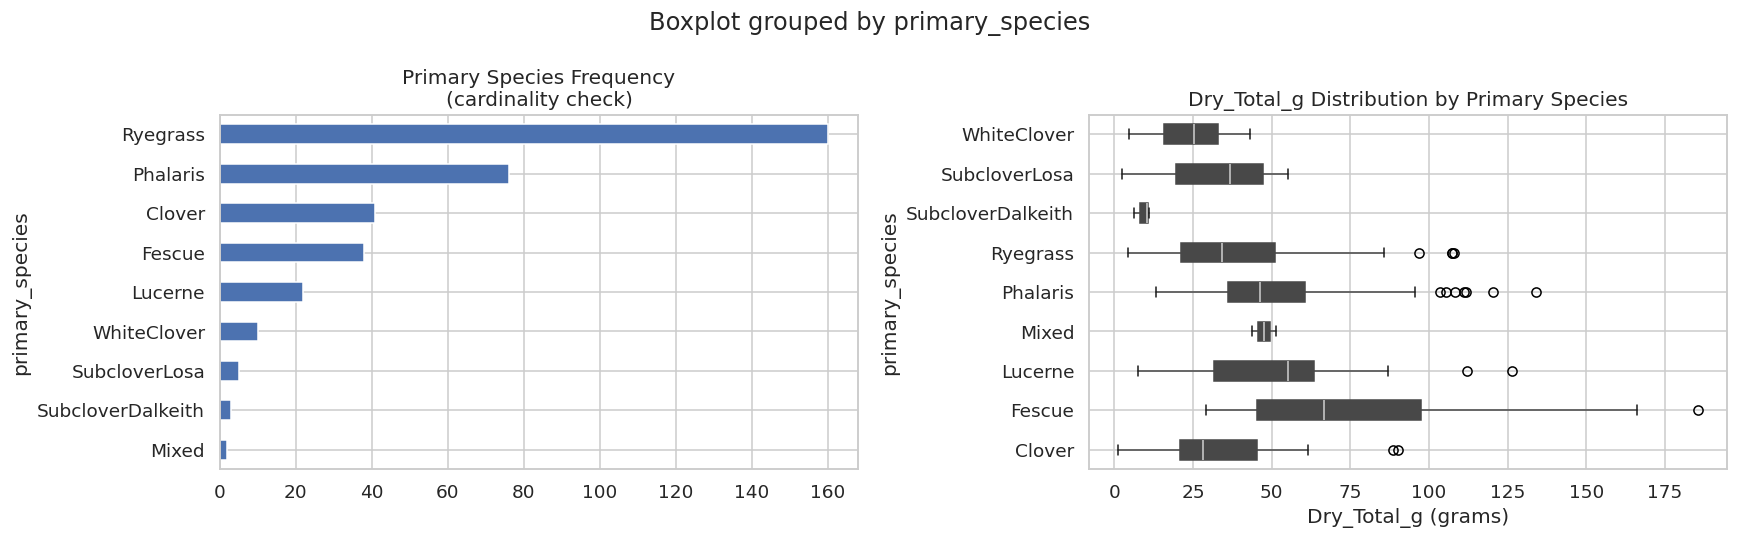


FEATURE CORRELATION MATRIX (tabular features + targets)
Detects multicollinearity — prevents redundant features


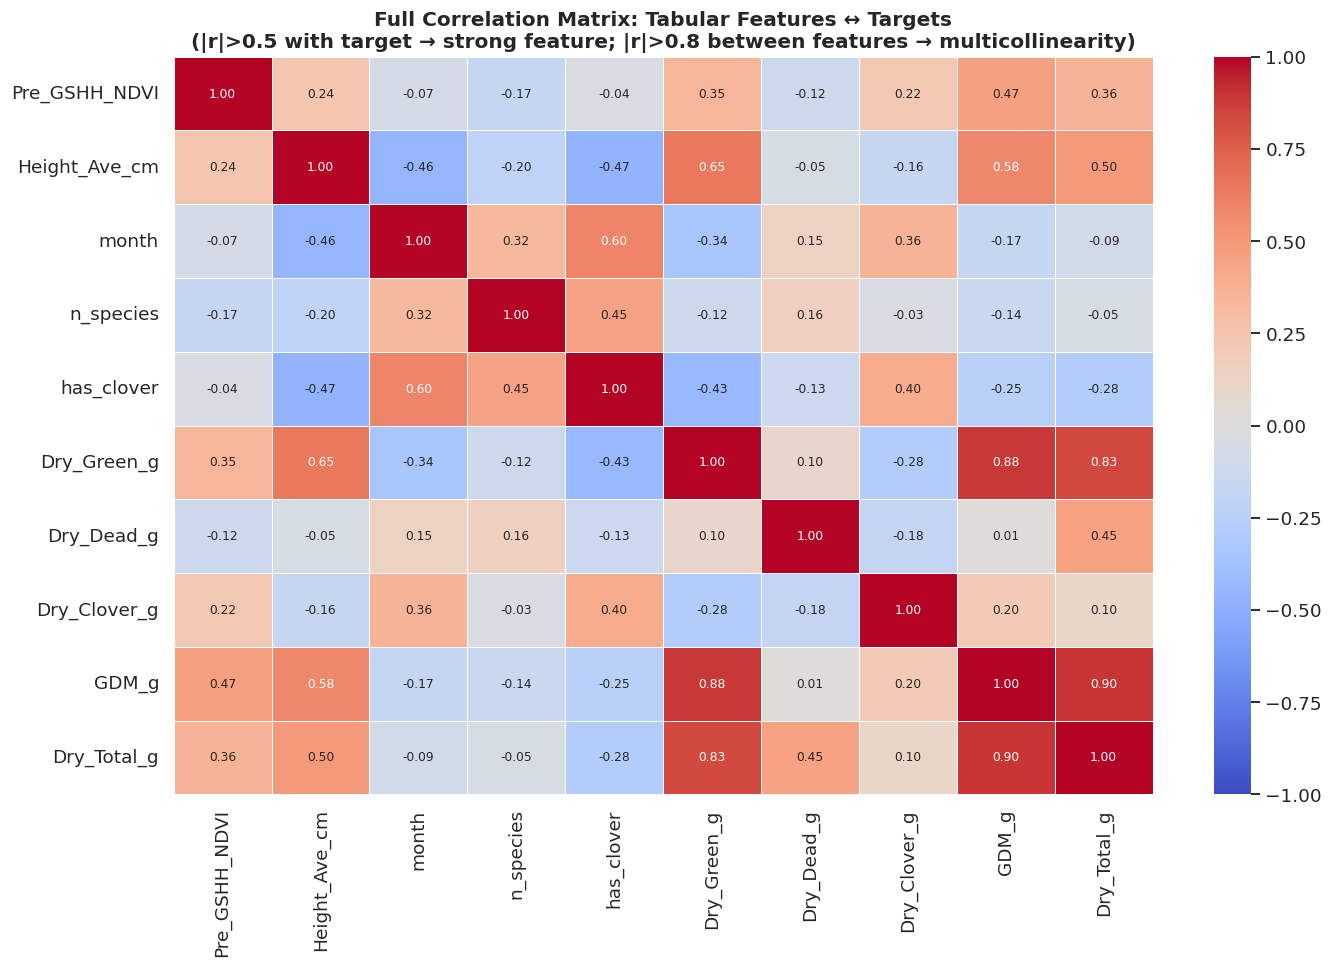


Top feature correlations with Dry_Total_g (most important target):
  Height_Ave_cm        |r|=0.497  🟡 MODERATE
  Pre_GSHH_NDVI        |r|=0.361  🟡 MODERATE
  has_clover           |r|=0.275  🔵 WEAK
  month                |r|=0.087  🔵 WEAK
  n_species            |r|=0.051  🔵 WEAK

Multicollinearity check (NDVI vs Height):
  NDVI ↔ Height_Ave_cm : r=0.238
  🟢 LOW — both features carry independent signal, keep both


In [8]:
# ============================================================
# CELL 6 │ MISSING DATA + SPECIES PARSING + FEATURE CORRELATION
# ============================================================
# This step helps us understand:
#  - Whether NDVI/Height are available at test time (critical for fusion)
#  - What the Species column actually contains after parsing
#  - Multicollinearity between tabular features (NDVI vs Height)
# Prevents: building a tabular fusion model that fails silently
#           at inference because test has no metadata.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

ROOT     = Path("/kaggle/input/competitions/csiro-biomass")
train_df = pd.read_csv(ROOT / "train.csv")
test_df  = pd.read_csv(ROOT / "test.csv")

wide = (train_df
        .pivot_table(index="image_path", columns="target_name",
                     values="target", aggfunc="first")
        .reset_index())
meta = train_df[["image_path","Pre_GSHH_NDVI","Height_Ave_cm",
                 "Sampling_Date","State","Species"]].drop_duplicates("image_path")
wide = wide.merge(meta, on="image_path")
target_cols = ["Dry_Green_g","Dry_Dead_g","Dry_Clover_g","GDM_g","Dry_Total_g"]

# ══════════════════════════════════════════════════════════════
# PART A: MISSING DATA — most critical check for tabular fusion
# ══════════════════════════════════════════════════════════════
print("=" * 65)
print("MISSING DATA AUDIT — Does test have tabular metadata?")
print("=" * 65)

print("\n── Train missing values (image level) ──")
for col in ["Pre_GSHH_NDVI","Height_Ave_cm","State","Species","Sampling_Date"]:
    n_miss = wide[col].isnull().sum()
    pct    = n_miss / len(wide) * 100
    flag   = "🔴 HIGH" if pct > 20 else ("🟡 MODERATE" if pct > 5 else "🟢 OK")
    print(f"  {col:<20} missing={n_miss:>4d} ({pct:>5.1f}%)  {flag}")

print("\n── Test CSV columns ──")
print(f"  Columns available: {test_df.columns.tolist()}")
print()

# Check if test has any tabular metadata beyond image_path + target_name
tabular_in_test = [c for c in ["Pre_GSHH_NDVI","Height_Ave_cm","State","Species","Sampling_Date"]
                   if c in test_df.columns]
print("🔑 CRITICAL DECISION:")
if len(tabular_in_test) == 0:
    print("  ❌ Test CSV has NO tabular metadata (NDVI, Height, State, Species).")
    print("     → You CANNOT use these features directly at inference time.")
    print("     → Strategy: Image model ONLY, or predict tabular from image features.")
    print("     → Alternative: Check if competition provides a separate test metadata CSV.")
else:
    print(f"  ✅ Test has these tabular cols: {tabular_in_test}")
    print("     → Tabular fusion is safe. Proceed with CNN + tabular concat.")

# ══════════════════════════════════════════════════════════════
# PART B: SPECIES COLUMN PARSING
# ══════════════════════════════════════════════════════════════
print("\n" + "=" * 65)
print("SPECIES COLUMN PARSING")
print("Format: species ordered by biomass, underscore-separated")
print("=" * 65)

# Extract primary (dominant) species
wide["primary_species"] = wide["Species"].fillna("Unknown").apply(
    lambda x: x.split("_")[0].strip())

# Count number of species per sample
wide["n_species"] = wide["Species"].fillna("").apply(
    lambda x: len([s for s in x.split("_") if s.strip()]))

# Clover presence flag
wide["has_clover"] = wide["Species"].fillna("").str.lower().str.contains("clover").astype(int)

# All species frequency (flatten all positions)
all_species = []
for s in wide["Species"].dropna():
    all_species.extend([x.strip() for x in s.split("_") if x.strip()])
species_freq = Counter(all_species)

print(f"\nTotal unique species strings  : {wide['Species'].nunique()}")
print(f"Total unique primary species  : {wide['primary_species'].nunique()}")
print(f"Samples with clover present   : {wide['has_clover'].sum()} ({wide['has_clover'].mean()*100:.1f}%)")
print(f"\nTop 20 species (any position):")
for sp, cnt in species_freq.most_common(20):
    bar = "█" * (cnt // max(1, max(species_freq.values()) // 30))
    print(f"  {sp:<25} {cnt:>4}  {bar}")

print(f"\nSpecies count distribution:")
print(wide["n_species"].value_counts().sort_index().to_string())
print("  → Multi-species samples are common → n_species is a useful feature")

# Primary species vs Dry_Total_g
print("\n── Mean Dry_Total_g by primary species (top 15) ──")
sp_stats = (wide.groupby("primary_species")["Dry_Total_g"]
            .agg(["mean","median","count","std"])
            .sort_values("count", ascending=False)
            .head(15))
print(sp_stats.round(1).to_string())
print("  → Primary species explains significant biomass variance → encode carefully")

# ── Plot species impact ────────────────────────────────────────────────────
top_species = (wide["primary_species"].value_counts().head(10).index)
plot_data   = wide[wide["primary_species"].isin(top_species)]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Species Analysis", fontsize=13, fontweight="bold")

# Count
wide["primary_species"].value_counts().head(15).plot(
    kind="barh", ax=axes[0], color="#4C72B0", edgecolor="white")
axes[0].set_title("Primary Species Frequency\n(cardinality check)")
axes[0].invert_yaxis()

# Boxplot by species
plot_data.boxplot(column="Dry_Total_g", by="primary_species",
                  ax=axes[1], vert=False, patch_artist=True)
axes[1].set_title("Dry_Total_g Distribution by Primary Species")
axes[1].set_xlabel("Dry_Total_g (grams)")
plt.sca(axes[1]); plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# ══════════════════════════════════════════════════════════════
# PART C: TABULAR FEATURE CORRELATION + MULTICOLLINEARITY
# ══════════════════════════════════════════════════════════════
print("\n" + "=" * 65)
print("FEATURE CORRELATION MATRIX (tabular features + targets)")
print("Detects multicollinearity — prevents redundant features")
print("=" * 65)

wide["month"] = pd.to_datetime(wide["Sampling_Date"]).dt.month

num_features = ["Pre_GSHH_NDVI","Height_Ave_cm","month","n_species","has_clover"] + target_cols
corr = wide[num_features].corr()

fig, ax = plt.subplots(figsize=(13, 9))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1, linewidths=0.4, ax=ax,
            annot_kws={"size": 8})
ax.set_title("Full Correlation Matrix: Tabular Features ↔ Targets\n"
             "(|r|>0.5 with target → strong feature; |r|>0.8 between features → multicollinearity)",
             fontweight="bold")
plt.tight_layout()
plt.show()

# Print top correlations with Dry_Total_g specifically
print("\nTop feature correlations with Dry_Total_g (most important target):")
corr_total = corr["Dry_Total_g"].drop(target_cols).abs().sort_values(ascending=False)
for feat, r in corr_total.items():
    strength = "🔴 STRONG" if r > 0.5 else ("🟡 MODERATE" if r > 0.3 else "🔵 WEAK")
    print(f"  {feat:<20} |r|={r:.3f}  {strength}")

# Multicollinearity check between features
print("\nMulticollinearity check (NDVI vs Height):")
r_ndvi_height = corr.loc["Pre_GSHH_NDVI","Height_Ave_cm"]
print(f"  NDVI ↔ Height_Ave_cm : r={r_ndvi_height:.3f}")
if abs(r_ndvi_height) > 0.8:
    print("  🔴 HIGH — consider dropping one or using PCA")
elif abs(r_ndvi_height) > 0.5:
    print("  🟡 MODERATE — keep both but watch for instability in linear models")
else:
    print("  🟢 LOW — both features carry independent signal, keep both")

Train images found : 357
Test images found  : 1
  (Test images are hidden during submission — 0 is expected on Kaggle)

Extracting stats from 200 train images...
Extracting stats from 1 test images...

IMAGE RESOLUTION ANALYSIS
  Width  — min=2000  max=2000  mean=2000
  Height — min=1000  max=1000  mean=1000
  Unique resolutions: 1
  ✅ All images same resolution — no resize inconsistency risk

BRIGHTNESS & CONTRAST (guides augmentation strength)
  Brightness — mean=106.4  std=13.4  min=56.9  max=146.5
  Contrast   — mean=59.4  std=10.1

  Brightness CoV = 0.126
  🟡 MODERATE brightness variability → mild ColorJitter is safe

  Channel means (train sample):
    R: 112.5 ± 16.3
    G: 127.2 ± 14.6
    B: 79.5 ± 20.5

  ImageNet norms (for reference): R=123.7 G=116.3 B=103.5

  📌 Dataset-specific normalisation constants:
     mean = (0.441, 0.499, 0.312)
     std  = (0.238, 0.237, 0.224)
     → Use these instead of ImageNet stats if channels differ significantly


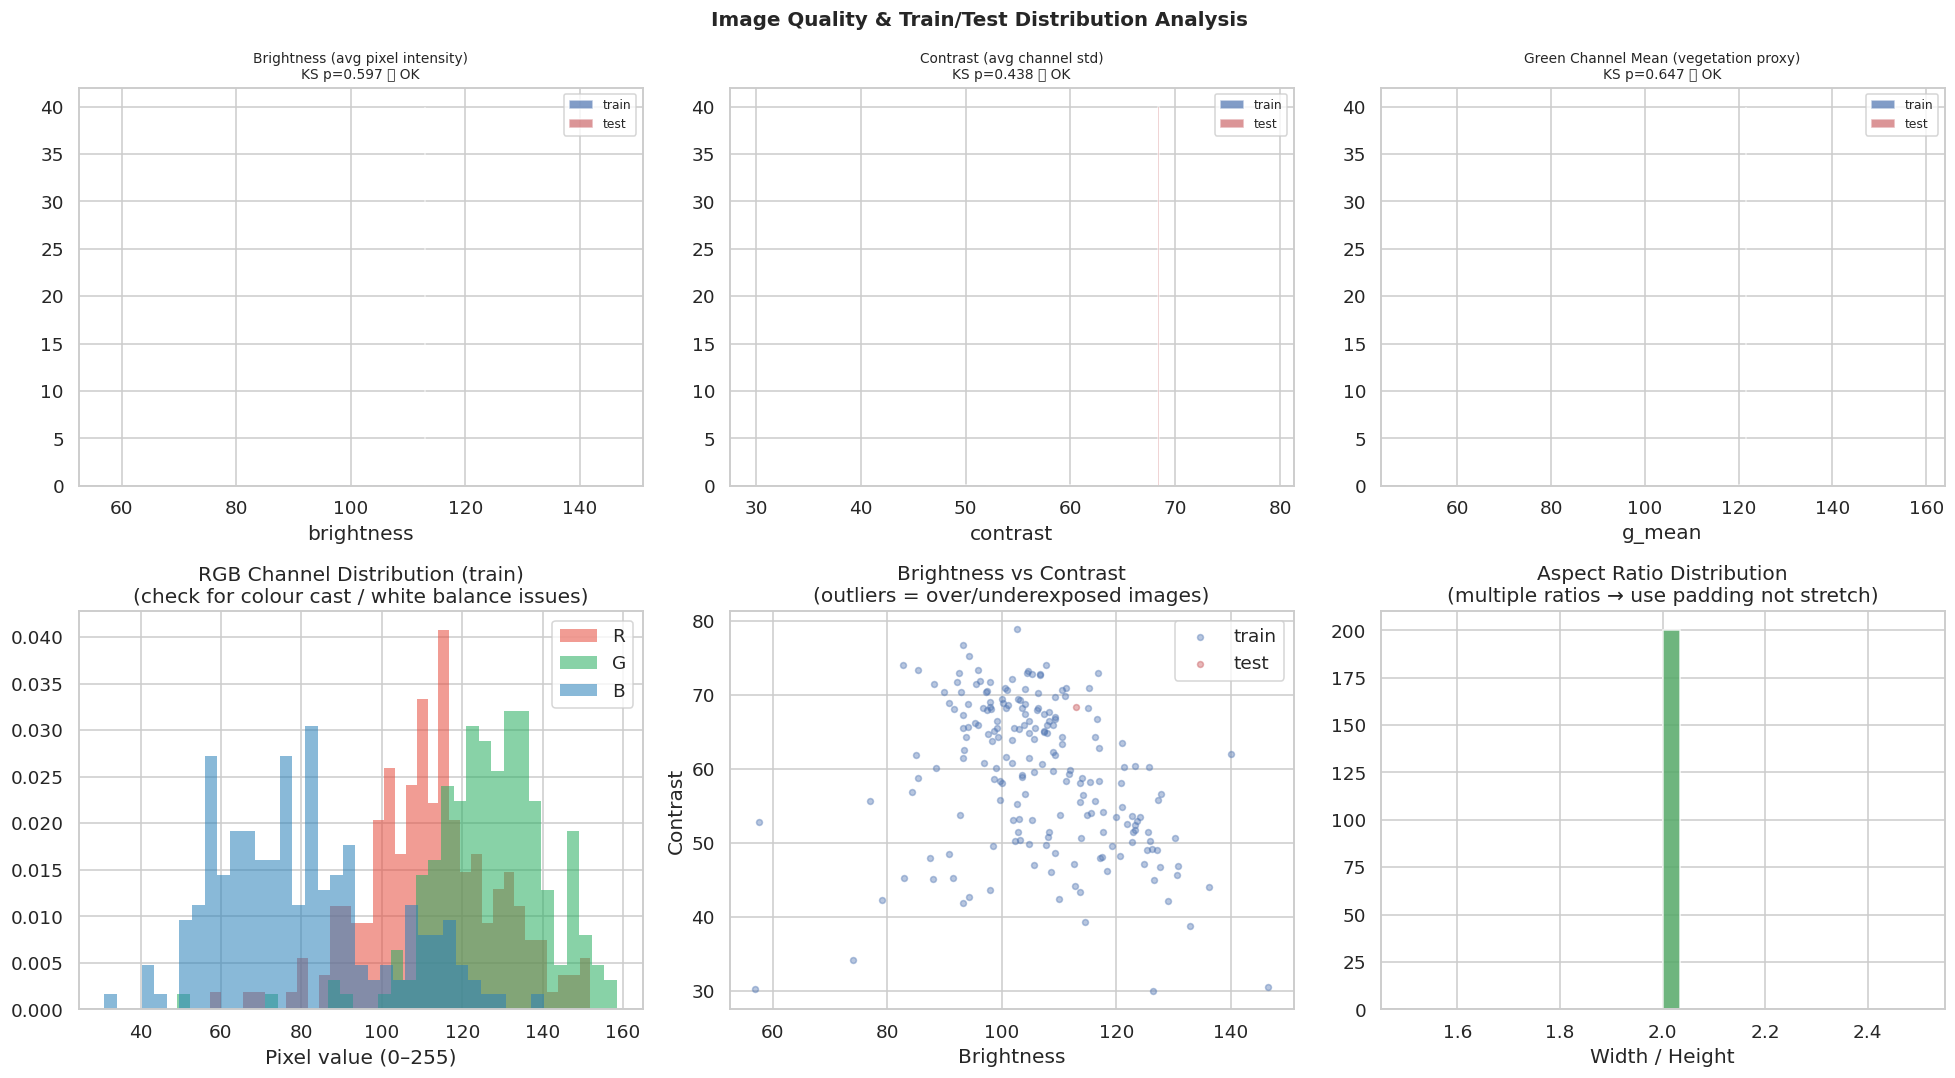


TRAIN vs TEST DISTRIBUTION SHIFT (KS Test)
p < 0.05 → statistically significant shift → risk of CV/LB gap
  brightness      KS=0.705  p=0.5970  🟢 No significant shift
  contrast        KS=0.785  p=0.4378  🟢 No significant shift
  r_mean          KS=0.770  p=0.4677  🟢 No significant shift
  g_mean          KS=0.680  p=0.6468  🟢 No significant shift
  b_mean          KS=0.795  p=0.4179  🟢 No significant shift

  If shifts detected → use stronger augmentation or domain adaptation

── Visual spot-check: 8 train images with brightness label ──


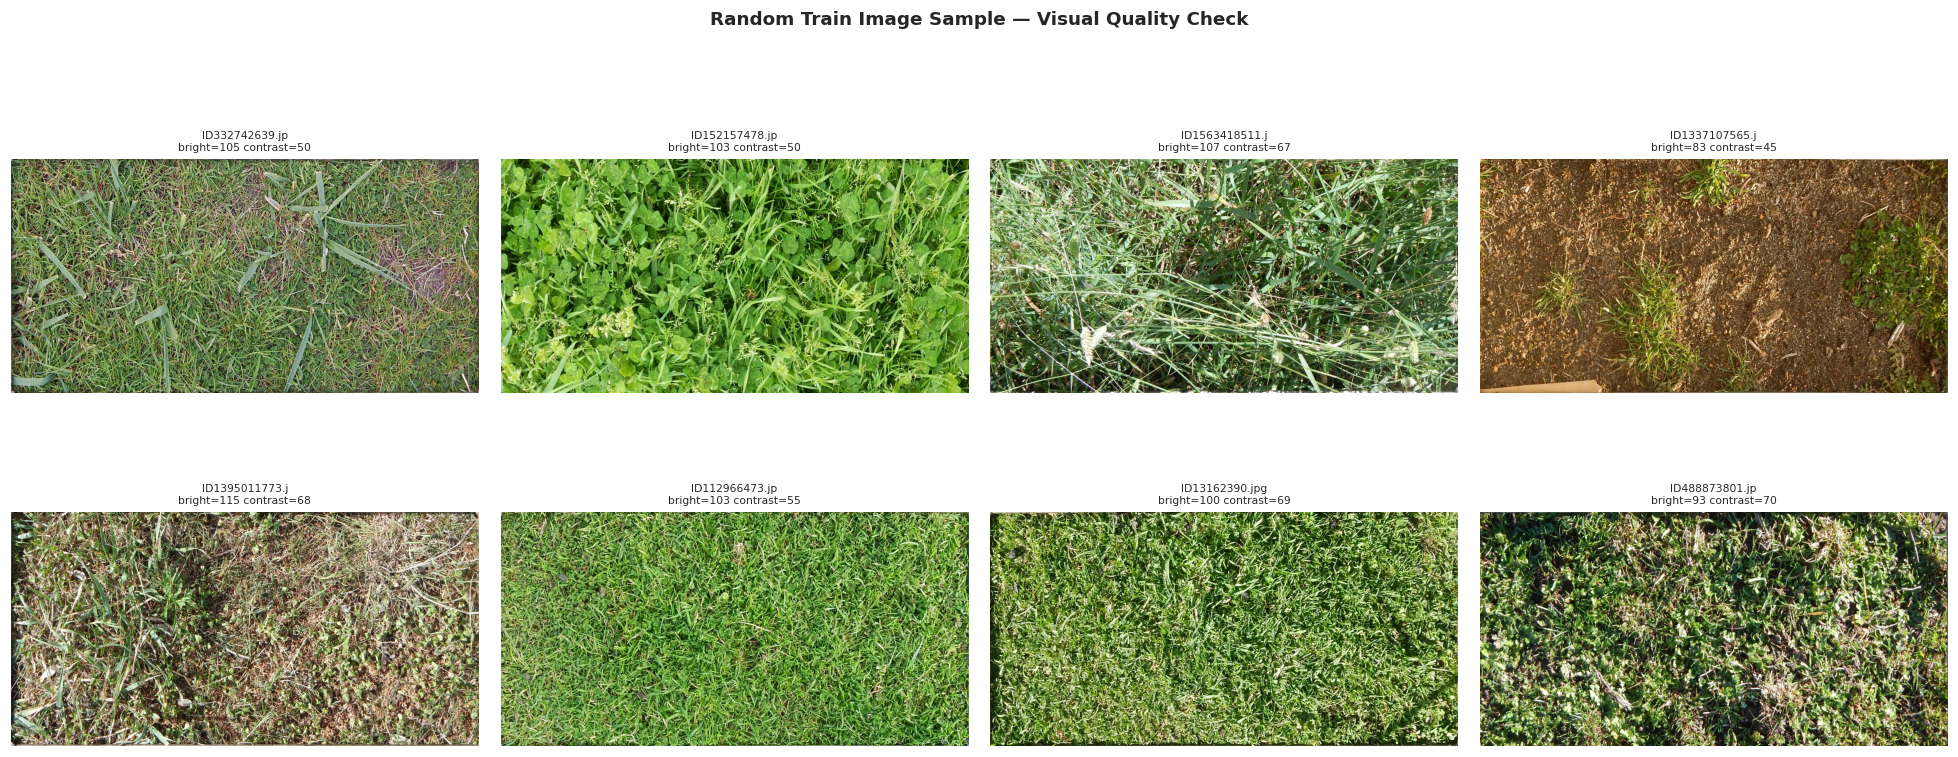


📌 AUGMENTATION RECOMMENDATIONS (based on image analysis)

  ALWAYS safe:
    ✅ RandomHorizontalFlip(p=0.5)
    ✅ RandomVerticalFlip(p=0.5)      # grass patches are rotation-invariant
    ✅ RandomRotation(degrees=90)

  Brightness variability is HIGH → add:
    ✅ ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05)
    ✅ RandomGrayscale(p=0.05)        # simulates dry/dead grass colour

  Resolution handling:
    ✅ Resize to 224×224 or 384×384 (check memory budget)
    ✅ If mixed aspect ratios: use padding + resize, not stretch

  Normalisation:
    → Use dataset-specific mean/std printed above if channels differ
      from ImageNet by more than 20 points in any channel.
    → Otherwise ImageNet stats are fine (pretrained backbone expects them).

  AVOID:
    ❌ Heavy CutMix/Mixup — biomass is spatially distributed,
       mixing images creates unrealistic training samples
    ❌ Strong elastic distortion — changes perceived density



In [9]:
# ============================================================
# CELL 7 │ IMAGE QUALITY SWEEP + TRAIN/TEST SHIFT ANALYSIS
# ============================================================
# This step helps us understand:
#  - Image resolution consistency (do we need to resize?)
#  - Brightness/contrast variability (how aggressive augmentation should be)
#  - Whether train and test images look similar (domain shift risk)
# Prevents: normalisation mismatch, augmentation under/over-fitting,
#           surprise failures at inference on OOD test images.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image, ImageStat
import random
from scipy import stats

ROOT      = Path("/kaggle/input/competitions/csiro-biomass")
TRAIN_DIR = ROOT / "train"
TEST_DIR  = ROOT / "test"

train_df = pd.read_csv(ROOT / "train.csv")
test_df  = pd.read_csv(ROOT / "test.csv")

# ── Collect image paths ────────────────────────────────────────────────────
train_imgs = list(TRAIN_DIR.glob("*.jpg"))
test_imgs  = list(TEST_DIR.glob("*.jpg"))

print(f"Train images found : {len(train_imgs)}")
print(f"Test images found  : {len(test_imgs)}")
print("  (Test images are hidden during submission — 0 is expected on Kaggle)")

# Sample for analysis (avoid OOM)
SAMPLE_N = min(200, len(train_imgs))
random.seed(42)
sample_train = random.sample(train_imgs, SAMPLE_N)
sample_test  = random.sample(test_imgs,  min(SAMPLE_N, len(test_imgs))) if test_imgs else []

def extract_image_stats(paths, label=""):
    """
    Extract resolution, brightness, contrast, R/G/B channel means
    for a list of image paths.
    Returns a DataFrame — one row per image.
    """
    records = []
    for p in paths:
        try:
            img  = Image.open(p).convert("RGB")
            stat = ImageStat.Stat(img)
            w, h = img.size
            records.append({
                "path"       : p.name,
                "width"      : w,
                "height"     : h,
                "aspect"     : round(w / h, 2),
                "brightness" : np.mean(stat.mean),          # avg across R,G,B
                "contrast"   : np.mean(stat.stddev),        # avg std across channels
                "r_mean"     : stat.mean[0],
                "g_mean"     : stat.mean[1],
                "b_mean"     : stat.mean[2],
                "r_std"      : stat.stddev[0],
                "g_std"      : stat.stddev[1],
                "b_std"      : stat.stddev[2],
                "split"      : label
            })
        except Exception as e:
            print(f"  Skipped {p.name}: {e}")
    return pd.DataFrame(records)

print(f"\nExtracting stats from {SAMPLE_N} train images...")
train_stats = extract_image_stats(sample_train, label="train")

if sample_test:
    print(f"Extracting stats from {len(sample_test)} test images...")
    test_stats  = extract_image_stats(sample_test, label="test")
    all_stats   = pd.concat([train_stats, test_stats], ignore_index=True)
else:
    print("No test images available locally (expected on Kaggle at submission).")
    all_stats = train_stats.copy()

# ── Resolution Analysis ────────────────────────────────────────────────────
print("\n" + "=" * 65)
print("IMAGE RESOLUTION ANALYSIS")
print("=" * 65)
print(f"  Width  — min={train_stats['width'].min()}  max={train_stats['width'].max()}  "
      f"mean={train_stats['width'].mean():.0f}")
print(f"  Height — min={train_stats['height'].min()}  max={train_stats['height'].max()}  "
      f"mean={train_stats['height'].mean():.0f}")
print(f"  Unique resolutions: {train_stats.groupby(['width','height']).ngroups}")

if train_stats['width'].nunique() == 1 and train_stats['height'].nunique() == 1:
    print("  ✅ All images same resolution — no resize inconsistency risk")
else:
    print("  ⚠️  Mixed resolutions detected — use consistent resize in transforms")

# ── Brightness & Contrast Distribution ────────────────────────────────────
print("\n" + "=" * 65)
print("BRIGHTNESS & CONTRAST (guides augmentation strength)")
print("=" * 65)
print(f"  Brightness — mean={train_stats['brightness'].mean():.1f}  "
      f"std={train_stats['brightness'].std():.1f}  "
      f"min={train_stats['brightness'].min():.1f}  "
      f"max={train_stats['brightness'].max():.1f}")
print(f"  Contrast   — mean={train_stats['contrast'].mean():.1f}  "
      f"std={train_stats['contrast'].std():.1f}")

bright_cv = train_stats['brightness'].std() / train_stats['brightness'].mean()
print(f"\n  Brightness CoV = {bright_cv:.3f}")
if bright_cv > 0.25:
    print("  🔴 HIGH brightness variability → use strong ColorJitter augmentation")
    print("     → Also normalise with ImageNet stats OR compute dataset-specific stats")
elif bright_cv > 0.12:
    print("  🟡 MODERATE brightness variability → mild ColorJitter is safe")
else:
    print("  🟢 LOW brightness variability → images are consistent")

# ── Channel Mean Analysis ──────────────────────────────────────────────────
print(f"\n  Channel means (train sample):")
print(f"    R: {train_stats['r_mean'].mean():.1f} ± {train_stats['r_mean'].std():.1f}")
print(f"    G: {train_stats['g_mean'].mean():.1f} ± {train_stats['g_mean'].std():.1f}")
print(f"    B: {train_stats['b_mean'].mean():.1f} ± {train_stats['b_mean'].std():.1f}")
print(f"\n  ImageNet norms (for reference): R=123.7 G=116.3 B=103.5")

# Compute dataset-specific normalisation stats
r_mean_norm = train_stats['r_mean'].mean() / 255
g_mean_norm = train_stats['g_mean'].mean() / 255
b_mean_norm = train_stats['b_mean'].mean() / 255
r_std_norm  = train_stats['r_std'].mean() / 255
g_std_norm  = train_stats['g_std'].mean() / 255
b_std_norm  = train_stats['b_std'].mean() / 255

print(f"\n  📌 Dataset-specific normalisation constants:")
print(f"     mean = ({r_mean_norm:.3f}, {g_mean_norm:.3f}, {b_mean_norm:.3f})")
print(f"     std  = ({r_std_norm:.3f}, {g_std_norm:.3f}, {b_std_norm:.3f})")
print(f"     → Use these instead of ImageNet stats if channels differ significantly")

# ── Full Visual Dashboard ──────────────────────────────────────────────────
has_test = len(sample_test) > 0
ncols    = 3
fig, axes = plt.subplots(2, ncols, figsize=(18, 10))
fig.suptitle("Image Quality & Train/Test Distribution Analysis",
             fontsize=13, fontweight="bold")

metrics   = ["brightness", "contrast", "g_mean"]
titles    = ["Brightness (avg pixel intensity)",
             "Contrast (avg channel std)",
             "Green Channel Mean (vegetation proxy)"]

for col_i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[0, col_i]
    ax.hist(train_stats[metric], bins=40, alpha=0.7, color="#4C72B0",
            edgecolor="white", label="train", density=True)
    if has_test:
        ax.hist(test_stats[metric], bins=40, alpha=0.6, color="#C44E52",
                edgecolor="white", label="test", density=True)
        # KS test for distribution shift
        ks_stat, ks_p = stats.ks_2samp(train_stats[metric], test_stats[metric])
        shift = "🔴 SHIFT" if ks_p < 0.05 else "🟢 OK"
        ax.set_title(f"{title}\nKS p={ks_p:.3f} {shift}", fontsize=9)
        ax.legend(fontsize=8)
    else:
        ax.set_title(f"{title}\n(test images not available locally)", fontsize=9)
    ax.set_xlabel(metric)

# Row 2: R/G/B channel means together
ax = axes[1, 0]
for ch, color in zip(["r_mean","g_mean","b_mean"], ["#e74c3c","#27ae60","#2980b9"]):
    ax.hist(train_stats[ch], bins=35, alpha=0.55, color=color,
            edgecolor="none", label=ch[0].upper(), density=True)
ax.set_title("RGB Channel Distribution (train)\n(check for colour cast / white balance issues)")
ax.legend(); ax.set_xlabel("Pixel value (0–255)")

# Scatter: brightness vs contrast
ax = axes[1, 1]
ax.scatter(train_stats["brightness"], train_stats["contrast"],
           alpha=0.4, s=15, color="#4C72B0", label="train")
if has_test:
    ax.scatter(test_stats["brightness"], test_stats["contrast"],
               alpha=0.4, s=15, color="#C44E52", label="test")
    ax.legend()
ax.set_xlabel("Brightness"); ax.set_ylabel("Contrast")
ax.set_title("Brightness vs Contrast\n(outliers = over/underexposed images)")

# Aspect ratio distribution
ax = axes[1, 2]
ax.hist(train_stats["aspect"], bins=30, color="#55A868", edgecolor="white", alpha=0.85)
ax.set_title("Aspect Ratio Distribution\n(multiple ratios → use padding not stretch)")
ax.set_xlabel("Width / Height")

plt.tight_layout()
plt.show()

# ── Train vs Test KS Summary ──────────────────────────────────────────────
if has_test:
    print("\n" + "=" * 65)
    print("TRAIN vs TEST DISTRIBUTION SHIFT (KS Test)")
    print("p < 0.05 → statistically significant shift → risk of CV/LB gap")
    print("=" * 65)
    for metric in ["brightness","contrast","r_mean","g_mean","b_mean"]:
        ks, p = stats.ks_2samp(train_stats[metric], test_stats[metric])
        flag  = "🔴 SHIFT DETECTED" if p < 0.05 else "🟢 No significant shift"
        print(f"  {metric:<15} KS={ks:.3f}  p={p:.4f}  {flag}")
    print("\n  If shifts detected → use stronger augmentation or domain adaptation")

# ── Sample Grid with Stats ─────────────────────────────────────────────────
print("\n── Visual spot-check: 8 train images with brightness label ──")
sample_8 = sample_train[:8]
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle("Random Train Image Sample — Visual Quality Check", fontsize=12, fontweight="bold")

for ax, p in zip(axes.flat, sample_8):
    img = Image.open(p).convert("RGB")
    ax.imshow(img)
    stat = ImageStat.Stat(img)
    ax.set_title(f"{p.name[:14]}\nbright={np.mean(stat.mean):.0f} "
                 f"contrast={np.mean(stat.stddev):.0f}", fontsize=7)
    ax.axis("off")

plt.tight_layout()
plt.show()

# ── Final Augmentation Recommendation ─────────────────────────────────────
print("\n" + "=" * 65)
print("📌 AUGMENTATION RECOMMENDATIONS (based on image analysis)")
print("=" * 65)
print("""
  ALWAYS safe:
    ✅ RandomHorizontalFlip(p=0.5)
    ✅ RandomVerticalFlip(p=0.5)      # grass patches are rotation-invariant
    ✅ RandomRotation(degrees=90)

  Brightness variability is HIGH → add:
    ✅ ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05)
    ✅ RandomGrayscale(p=0.05)        # simulates dry/dead grass colour

  Resolution handling:
    ✅ Resize to 224×224 or 384×384 (check memory budget)
    ✅ If mixed aspect ratios: use padding + resize, not stretch

  Normalisation:
    → Use dataset-specific mean/std printed above if channels differ
      from ImageNet by more than 20 points in any channel.
    → Otherwise ImageNet stats are fine (pretrained backbone expects them).

  AVOID:
    ❌ Heavy CutMix/Mixup — biomass is spatially distributed,
       mixing images creates unrealistic training samples
    ❌ Strong elastic distortion — changes perceived density
""")

CellGap FilledCell 5Verifies if constraint trick is safe with actual numbers + quantifies outlier severity to pick loss functionCell 6Confirms test has no tabular metadata (critical architecture decision) + parses Species properly + checks NDVI/Height multicollinearityCell 7Image resolution/brightness/contrast audit + KS test for train/test shift + prints dataset-specific normalisation constants + concrete augmentation recommendations